In [835]:
import ROOT
from ROOT import TCanvas, TPad, TFile, TPaveLabel, TPaveText, TH1F, TH2F
from ROOT import gROOT, gBenchmark, gRandom, gSystem, RDataFrame

import pandas as pd
from multiprocessing import Pool
import random
import numpy as np

import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import crystalball

from sklearn.neighbors import LocalOutlierFactor

from skimage.io import imread, imshow
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
from skimage import color, exposure, transform
from skimage.exposure import equalize_hist

from sklearn.neural_network import MLPRegressor

import janitor

from tqdm import tqdm

import tensorflow as tf
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [205]:
data = RDataFrame("t;1", "FullSim_E5GeV.root").AsNumpy()

KeyboardInterrupt: 

In [3]:
X = np.array(
    [
        data["part_p"],
        data["part_x"], 
        data["part_y"],
        data["part_z"],
        data["part_theta"],
        data["part_phi"]
    ]
).transpose()
obs = data["cl_E_ecal"]
del data

In [823]:
subset = (X_sel.transpose()[1]>500)*(X_sel.transpose()[1]<3500)*(X_sel.transpose()[2]>500)*(X_sel.transpose()[2]<2500)*(X_sel.transpose()[4]<0.6)*(X_sel.transpose()[5]<2*np.pi)
sum(subset)

51036783

In [824]:
X_sel, obs = X_sel[subset], obs[subset]

In [655]:
params = {
    "X": {
        "range": (500,3500),
        "reso": 0.1
    }, 
    "Y": {
        "range": (500,2500),
        "reso": None
    }
    , 
    "theta": {
        "range": (-1,0.6),
        "reso": 80
    }, 
    "phi": {
        "range": (1,2),
        "reso": None
    }
}
print(params.keys()-'phi')

{'phi', 'Y', 'theta', 'X'}


In [656]:
def make_img(data, obs, params, func=np.mean):
    ind_map = {
        "X": 1,
        "Y": 2,
        "theta": 4,
        "phi": 5
    }
    
    print(f"[1/2] binning data...")
    data = data.transpose()
    subset = (data[1] > params["X"]["range"][0])*(data[1] < params["X"]["range"][1])* \
             (data[2] > params["Y"]["range"][0])*(data[2] < params["Y"]["range"][1])* \
             (data[4] > params["theta"]["range"][0])*(data[4] < params["theta"]["range"][1])* \
             (data[5] > params["phi"]["range"][0])*(data[5] < params["phi"]["range"][1])
    data = data.transpose()[subset].transpose()
    binned_data = {"E": obs[subset]}
    for key in tqdm(params.keys()):
        if params[key]["reso"]:
            bins = data[ind_map[key]]*params[key]["reso"]
            binned_data[key] = bins.astype('int')
    print("[2/2] creating image...")
    df = pd.DataFrame(binned_data)
    df_binned =  df.groupby(list(binned_data.keys() - "E")).E.mean().unstack(fill_value=int(np.mean(obs))).stack().reset_index(name='E')
    E_by_bin = np.array(df_binned.E)
    return E_by_bin.reshape([int(max(binned_data[key]) - min(binned_data[key])+1) for key in list(binned_data.keys() - "E")])

def fft_filter(data, n_sigma = 3, make_plots = False, make_sparse = False):
    print(f"[1/2] performing fast Fourier transform along {len(data.shape)} axes...")
    data_fft = np.fft.fftn(data)
    cutoff = np.mean(np.log(abs(data_fft.flatten()))) + n_sigma*np.std(np.log(abs(data_fft.flatten())))
    print(f"[2/2] filtering Fourier transformed data with cutoff e^{cutoff}")
    if make_sparse:
        saved_points = []
        for index, E in tqdm(np.ndenumerate(data_fft)):
            if np.log(abs(E)) > cutoff:
                saved_points.append((index, E))
        return saved_points
    else:    
        for index, E in tqdm(np.ndenumerate(data_fft)):
            if np.log(abs(E)) < cutoff:
                data_fft[index] = 1 + 0j
            else:
                data_fft[index] = E
    if make_plots:
        plt.figure(figsize=(12,8))
        plt.imshow(data, cmap='gray', origin="lower")
        plt.show()
        plt.figure(figsize=(12,8))
        plt.imshow(abs(np.fft.ifftn(data_fft)), cmap='gray', origin="lower")
        plt.show()
    return data_fft

In [752]:
params = {
    "X": {
        "range": (500,3500),
        "reso": 0.1
    }, 
    "Y": {
        "range": (500,2500),
        "reso": 0.1
    }
    , 
    "theta": {
        "range": (-1,0.6),
        "reso": None
    }, 
    "phi": {
        "range": (-1,2*np.pi),
        "reso": None
    }
}
data_binned = make_img(X_sel, obs, params)

[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.61it/s]


[2/2] creating image...


[1/2] performing fast Fourier transform along 2 axes...
[2/2] filtering Fourier transformed data with cutoff e^7.21465883687573


60000it [00:00, 1453663.59it/s]


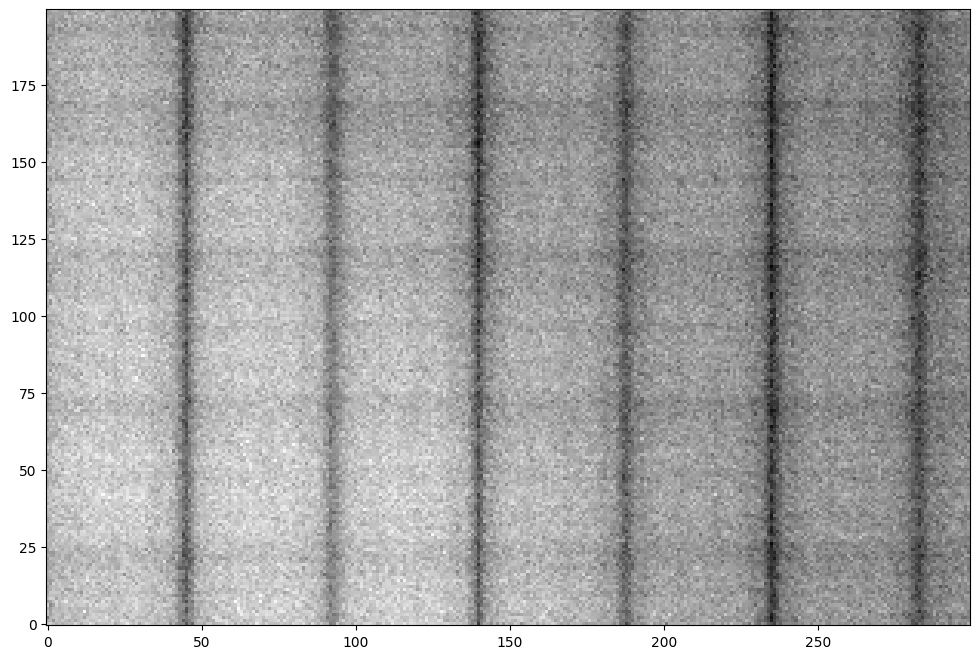

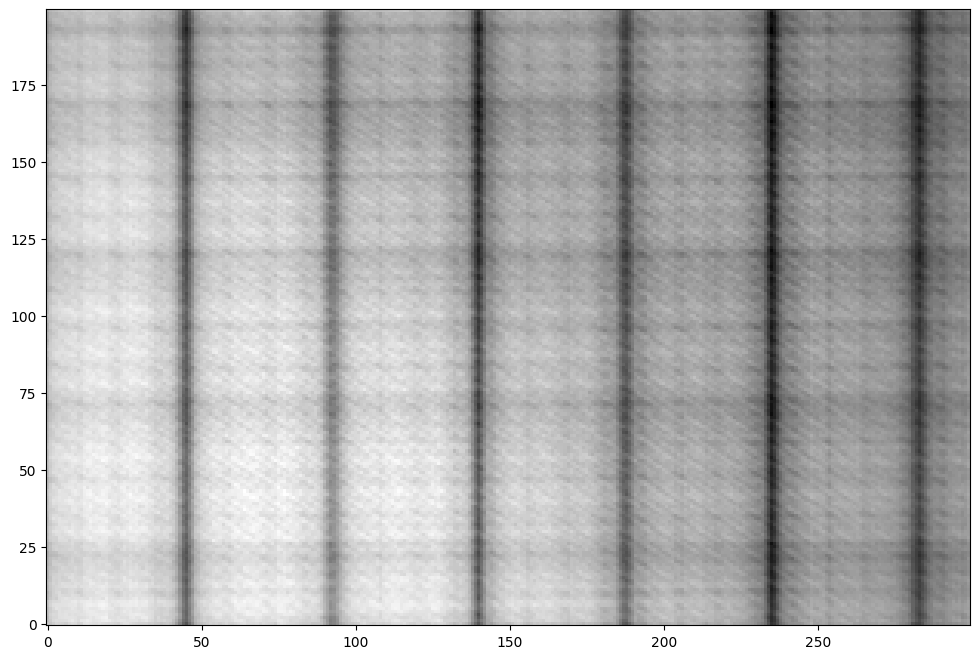

In [753]:
xy_fft_filt = fft_filter(data_binned, n_sigma = 2, make_plots=True)

In [754]:
len(fft_filter(data_binned, n_sigma = 2, make_sparse=True))

[1/2] performing fast Fourier transform along 2 axes...
[2/2] filtering Fourier transformed data with cutoff e^7.21465883687573


60000it [00:00, 1954414.59it/s]


397

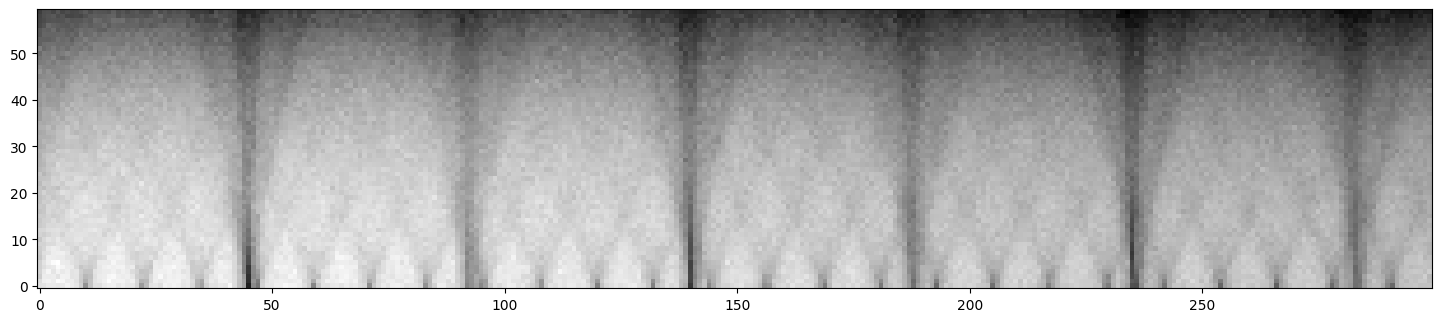

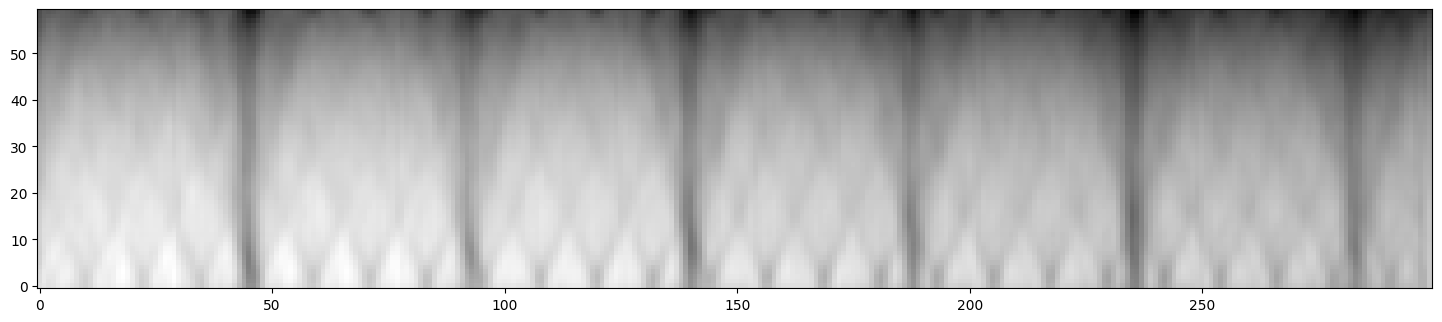

In [804]:
params_pairwise = {
    "X_v_Y": {
        "X": {
            "range": (500,3500),
            "reso": 0.1
        }, 
        "Y": {
            "range": (500,2500),
            "reso": 0.1
        }
        , 
        "theta": {
            "range": (0,0.6),
            "reso": None
        }, 
        "phi": {
            "range": (0,2*np.pi),
            "reso": None
        }
    },
    "X_v_theta": {
        "X": {
            "range": (500,3500),
            "reso": 0.1
        }, 
        "Y": {
            "range": (500,2500),
            "reso": None
        }
        , 
        "theta": {
            "range": (0,0.6),
            "reso": 100
        }, 
        "phi": {
            "range": (0,2*np.pi),
            "reso": None
        }
    },
    "X_v_phi": {
        "X": {
            "range": (500,3500),
            "reso": 0.1
        }, 
        "Y": {
            "range": (500,2500),
            "reso": None
        }
        , 
        "theta": {
            "range": (0,0.6),
            "reso": None
        }, 
        "phi": {
            "range": (0,2*np.pi),
            "reso": 10
        }
    },
    "Y_v_theta": {
        "X": {
            "range": (500,3500),
            "reso": None
        }, 
        "Y": {
            "range": (500,2500),
            "reso": 0.1
        }
        , 
        "theta": {
            "range": (0,0.6),
            "reso": 100
        }, 
        "phi": {
            "range": (0,2*np.pi),
            "reso": None
        }
    },
    "Y_v_phi": {
        "X": {
            "range": (500,3500),
            "reso": None
        }, 
        "Y": {
            "range": (500,2500),
            "reso": 0.1
        }
        , 
        "theta": {
            "range": (0,0.6),
            "reso": None
        }, 
        "phi": {
            "range": (0,2*np.pi),
            "reso": 10
        }
    },
    "theta_v_phi": {
        "X": {
            "range": (500,3500),
            "reso": None
        }, 
        "Y": {
            "range": (500,2500),
            "reso": None
        }
        , 
        "theta": {
            "range": (0,0.6),
            "reso": 100
        }, 
        "phi": {
            "range": (0,2*np.pi),
            "reso": 10
        }
    }
}

[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.37it/s]


[2/2] creating image...
Plotting X_v_Y
X range is (500, 3500)
X bin scaling is 10.0
Y range is (500, 2500)
Y bin scaling is 10.0
[1/2] performing fast Fourier transform along 2 axes...
[2/2] filtering Fourier transformed data with cutoff e^7.21465883687573


60000it [00:00, 1844609.58it/s]


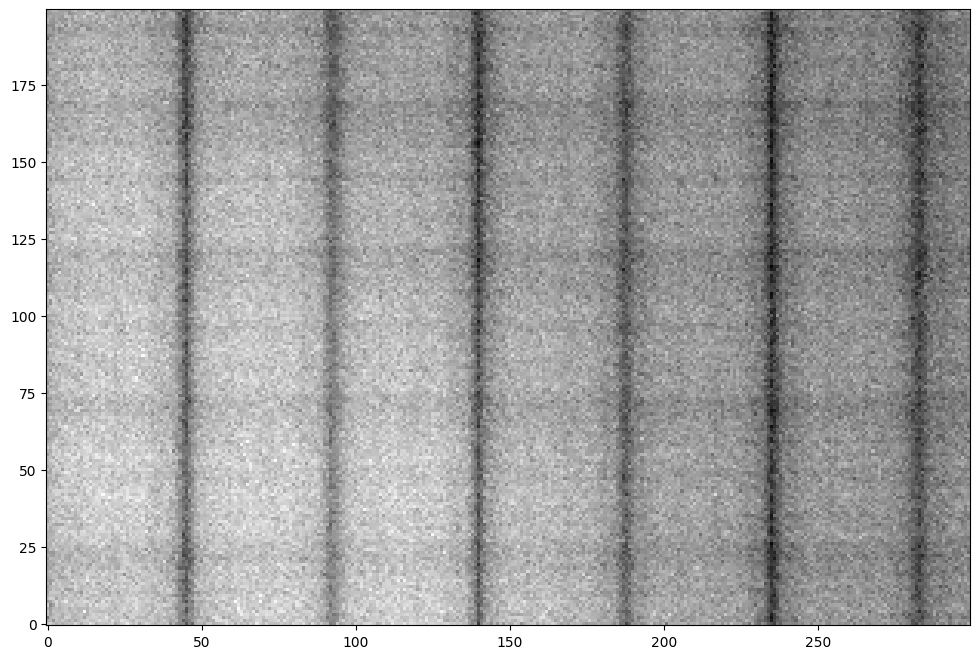

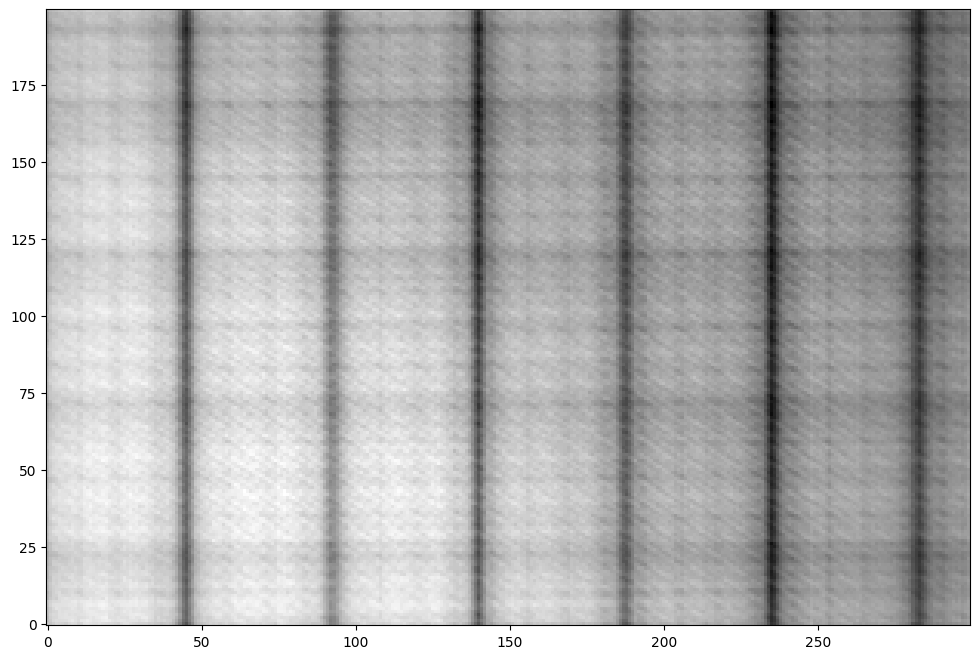

[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.85it/s]


[2/2] creating image...
Plotting X_v_theta
X range is (500, 3500)
X bin scaling is 10.0
theta range is (-1, 0.6)
theta bin scaling is 0.01
[1/2] performing fast Fourier transform along 2 axes...
[2/2] filtering Fourier transformed data with cutoff e^6.470216719890351


18000it [00:00, 1855886.73it/s]


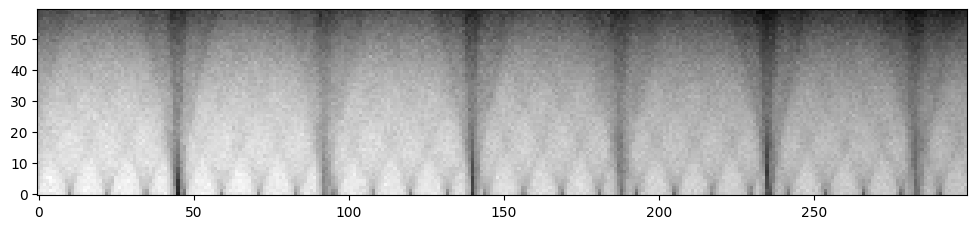

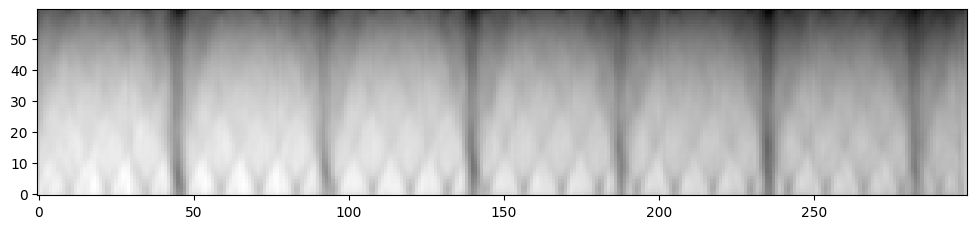

[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 27.84it/s]


[2/2] creating image...
Plotting X_v_phi
X range is (500, 3500)
X bin scaling is 10.0
phi range is (-1, 6.283185307179586)
phi bin scaling is 0.1
[1/2] performing fast Fourier transform along 2 axes...
[2/2] filtering Fourier transformed data with cutoff e^6.609588782100452


18900it [00:00, 1811359.69it/s]


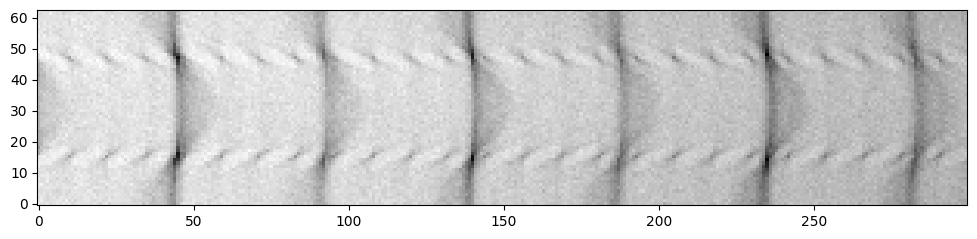

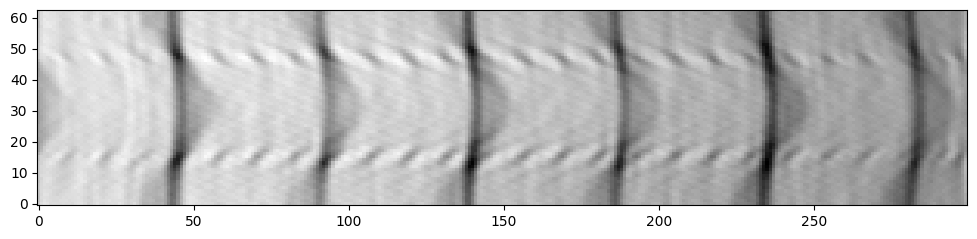

[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 25.64it/s]


[2/2] creating image...
Plotting Y_v_theta
Y range is (500, 2500)
Y bin scaling is 10.0
theta range is (-1, 0.6)
theta bin scaling is 0.01
[1/2] performing fast Fourier transform along 2 axes...
[2/2] filtering Fourier transformed data with cutoff e^6.008458256850861


12000it [00:00, 1912950.78it/s]


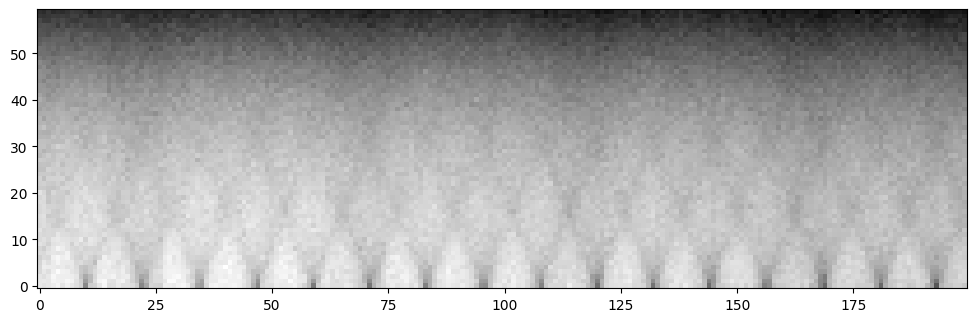

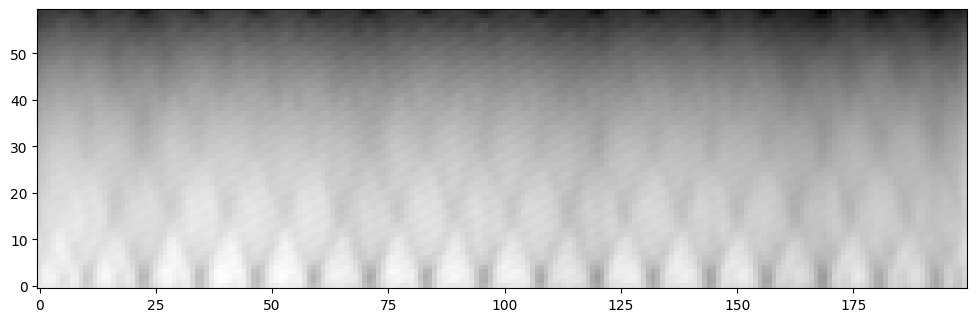

[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.93it/s]


[2/2] creating image...
Plotting Y_v_phi
Y range is (500, 2500)
Y bin scaling is 10.0
phi range is (-1, 6.283185307179586)
phi bin scaling is 0.1
[1/2] performing fast Fourier transform along 2 axes...
[2/2] filtering Fourier transformed data with cutoff e^6.012873281215696


12600it [00:00, 1850752.25it/s]


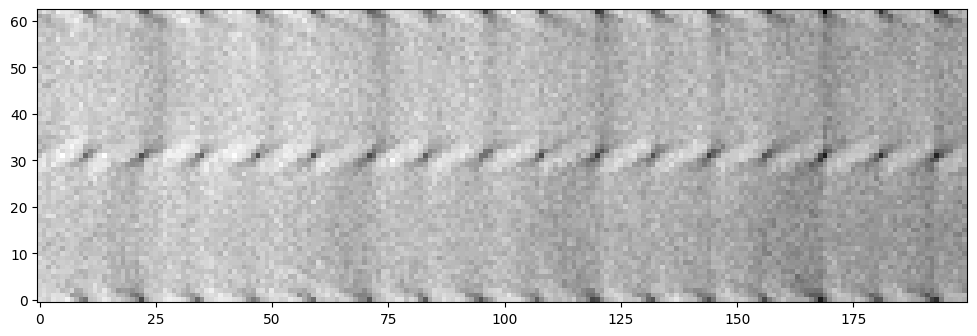

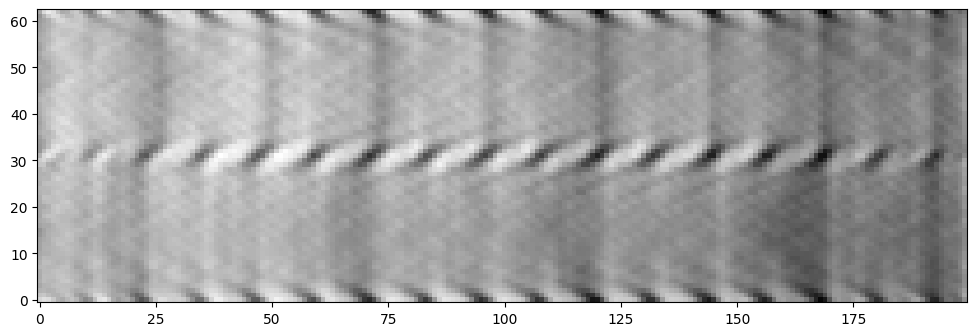

[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 25.22it/s]


[2/2] creating image...
Plotting theta_v_phi
theta range is (-1, 0.6)
theta bin scaling is 0.01
phi range is (-1, 6.283185307179586)
phi bin scaling is 0.1
[1/2] performing fast Fourier transform along 2 axes...
[2/2] filtering Fourier transformed data with cutoff e^4.893251355521109


3780it [00:00, 1744166.02it/s]


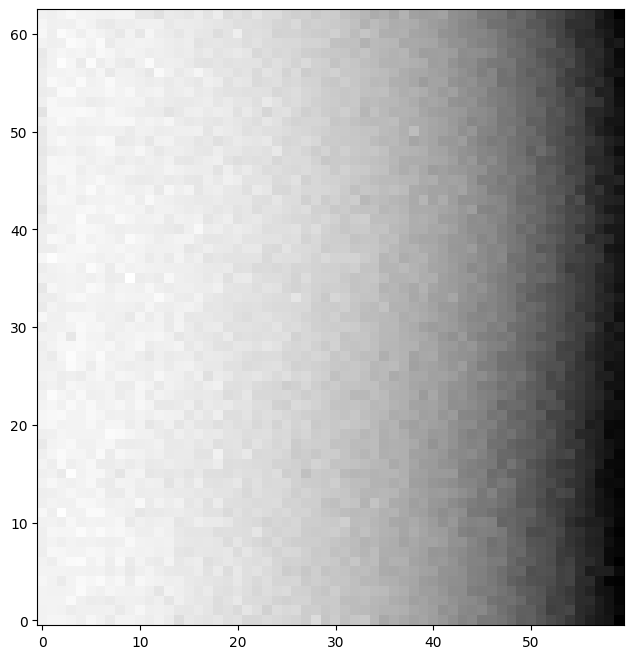

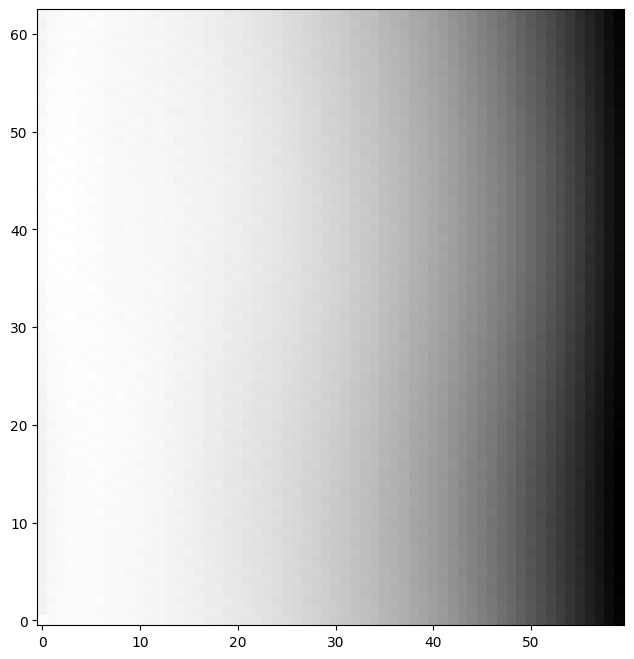

In [776]:
fft_filt_pw = {}
for key in params_pairwise.keys():
    data_binned = make_img(X_sel, obs, params_pairwise[key])
    print(f"Plotting {key}")
    print(f"{key.split("_")[0]} range is {params_pairwise[key][key.split("_")[0]]["range"]}")
    print(f"{key.split("_")[0]} bin scaling is {1/params_pairwise[key][key.split("_")[0]]["reso"]}")
    print(f"{key.split("_")[2]} range is {params_pairwise[key][key.split("_")[2]]["range"]}")
    print(f"{key.split("_")[2]} bin scaling is {1/params_pairwise[key][key.split("_")[2]]["reso"]}")
    fft_filt_pw[key] = fft_filter(data_binned, n_sigma = 2, make_plots=True)
    

In [781]:
ind_map = {
        "X": 1,
        "Y": 2,
        "theta": 4,
        "phi": 5,
        1: "X",
        2: "Y",
        4: "theta",
        5: "phi"
    }

ifft_filt_pw = {key: abs(np.fft.ifftn(fft_filt_pw[key])) for key in fft_filt_pw.keys()}

In [825]:
ifft_inputs = []
for row in tqdm(X_sel):
    ifft_row = []
    for key in ifft_filt_pw.keys():
        var_1 = (key.split("_")[0], ind_map[key.split("_")[0]])
        var_2 = (key.split("_")[2], ind_map[key.split("_")[2]])
        coordinates_scaled = (
            int((row[var_1[1]]-params_pairwise[key][var_1[0]]["range"][0])*params_pairwise[key][var_1[0]]["reso"]), 
            int((row[var_2[1]]-params_pairwise[key][var_2[0]]["range"][0])*params_pairwise[key][var_2[0]]["reso"])
        )
        ifft_val = ifft_filt_pw[key][coordinates_scaled[1], coordinates_scaled[0]]
        ifft_row.append(ifft_val)
    ifft_inputs.append(ifft_row)

100%|████████████████████████████████████████████████████████████████████████| 51036783/51036783 [13:27<00:00, 63207.65it/s]


In [831]:
ifft_inputs = np.array(ifft_inputs)

In [842]:
inputs = np.concatenate((X_sel, ifft_inputs), axis=1)

In [846]:
sel_ind = np.random.choice(ifft_inputs.shape[0], 5000000)
inputs_small = ifft_inputs[sel_ind]
obs_small = obs[sel_ind]

In [850]:
fft_avgs = np.apply_along_axis(np.mean, 1, inputs_small)

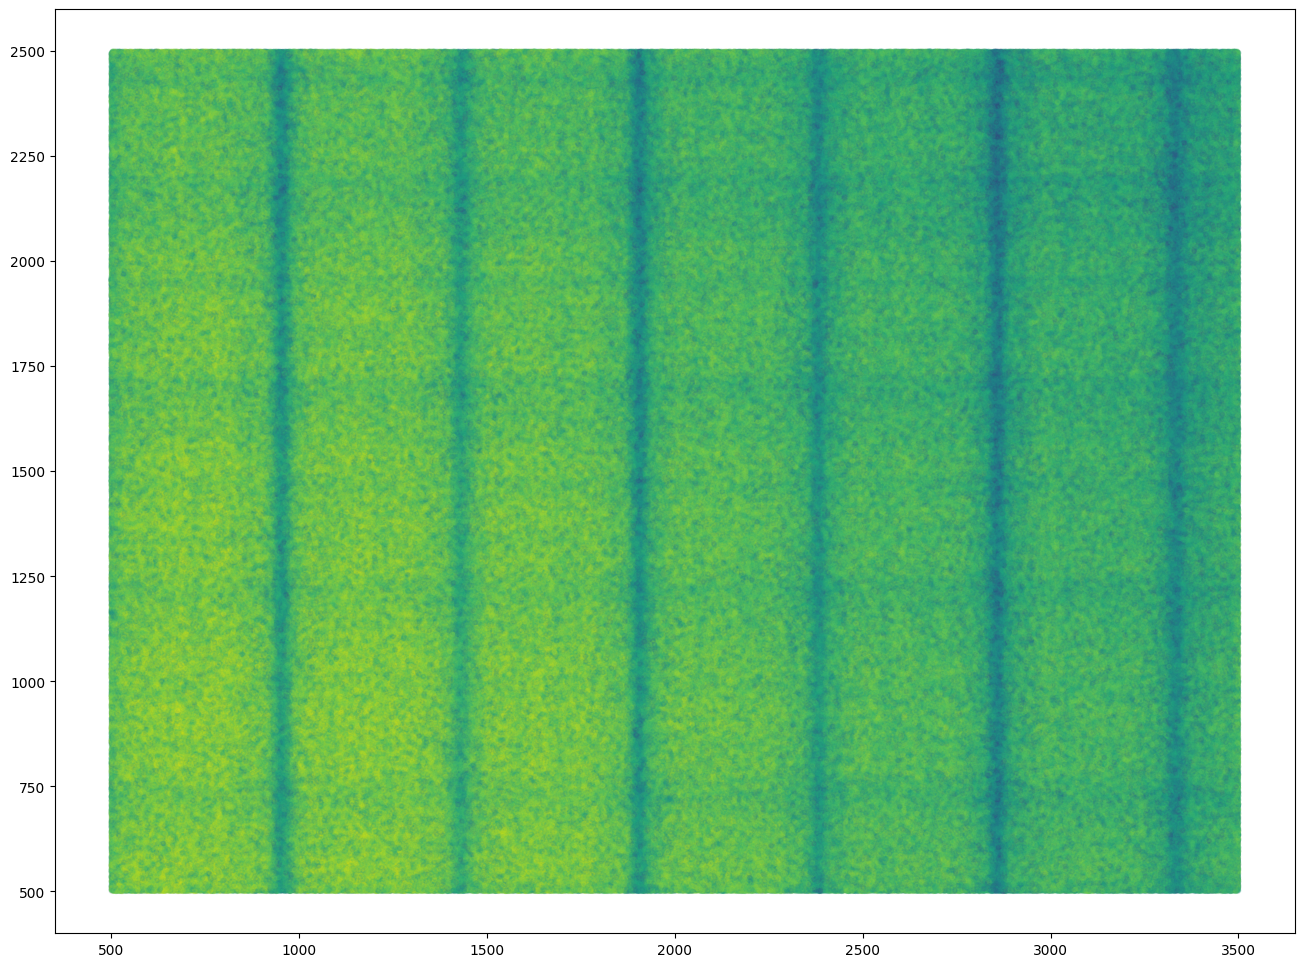

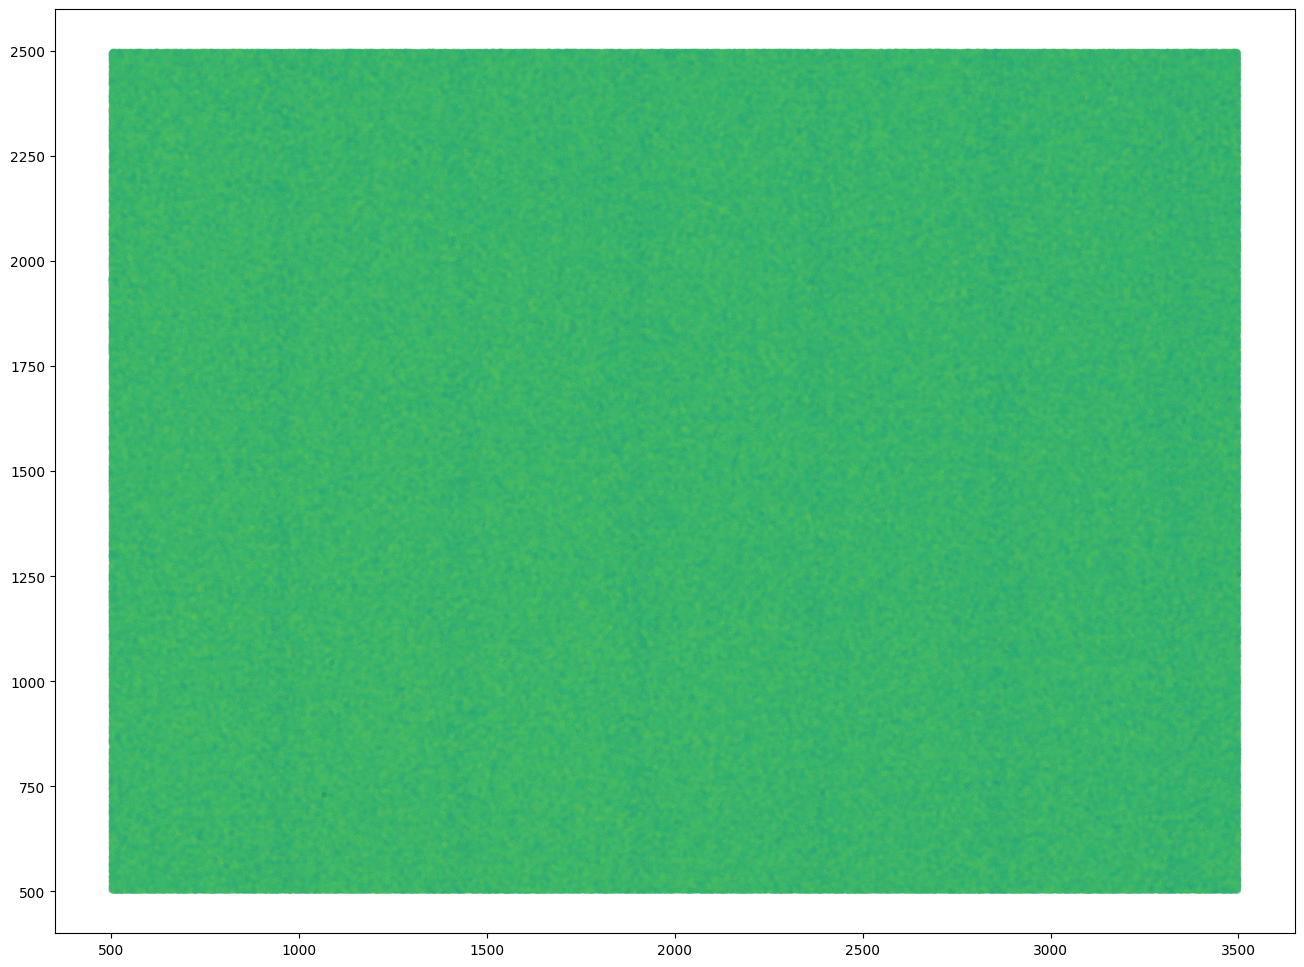

In [854]:
plt.figure(figsize=(16,12))
plt.scatter(np.transpose(X_sel[sel_ind])[1], np.transpose(X_sel[sel_ind])[2], c=fft_avgs, s=10, alpha=0.1)
plt.show()
plt.figure(figsize=(16,12))
plt.scatter(np.transpose(X_sel[sel_ind])[1], np.transpose(X_sel[sel_ind])[2], c=obs_small, s=10, alpha=0.1)
plt.show()

In [143]:
xy_binned_filt

array([[ 1.36409806e+07,  4.93377685e+03, -1.12784987e+03, ...,
         2.03504428e+03, -1.12784987e+03,  4.93377685e+03],
       [ 1.62101842e+03, -4.15528153e+03, -1.07102594e+03, ...,
         6.85640479e+02,  5.02254286e+02,  2.64421401e+03],
       [ 3.18989131e+03, -1.35503644e+03, -1.31307983e+02, ...,
        -1.07883687e+02, -2.75253474e+02,  1.65209346e+03],
       ...,
       [ 1.78509983e+03,  1.29078893e+03, -2.07249853e+02, ...,
        -7.83259227e+01, -2.69986702e+02, -1.46876511e+03],
       [ 3.18989131e+03,  1.65209346e+03, -2.75253474e+02, ...,
        -9.81513502e+01, -1.31307983e+02, -1.35503644e+03],
       [ 1.62101842e+03,  2.64421401e+03,  5.02254286e+02, ...,
        -2.33867487e+02, -1.07102594e+03, -4.15528153e+03]])

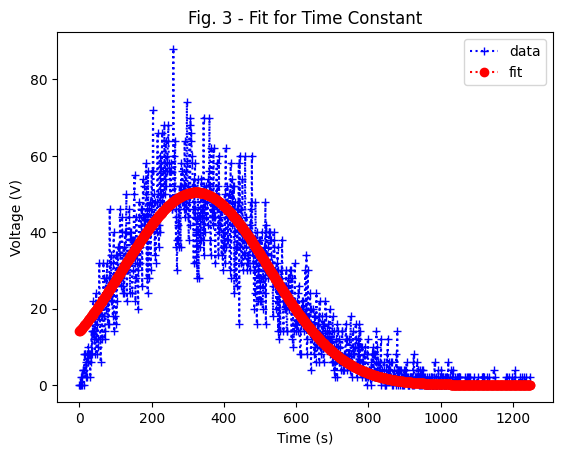

In [216]:
import pylab as plb
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from numpy import asarray as ar,exp

x= pred_bins[:-1]
y = pred_counts

n = len(x)                          #the number of data
mean = 750                   #note this correction
sigma = 100        #note this correction

def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])

plt.plot(x,y,'b+:',label='data')
plt.plot(x,gaus(x,*popt),'ro:',label='fit')
plt.legend()
plt.title('Fig. 3 - Fit for Time Constant')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.show()